In [1]:
import os
import numpy as np
import pandas as pd
import re

# from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import sequence
from sklearn import metrics

from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler


In [2]:
# import train/val/test data from the data exploration part

data_prep=np.load('data_prep.npz',allow_pickle=True)
train_text,train_label=data_prep['train_text'],data_prep['train_label']
val_text,val_label=data_prep['val_text'],data_prep['val_label']
test_text,test_label=data_prep['test_text'],data_prep['test_label']
voca_set=data_prep['voca_set'].tolist()

# define encoder and tokenizer
tokenizer=tfds.deprecated.text.Tokenizer()
encoder=tfds.deprecated.text.TokenTextEncoder(
    voca_set,tokenizer=tokenizer)

# 1. Pre-trained GloVe embeddings

In [3]:
# load the GloVe embeddings

dict_w2v={}

with open('GloVe_dict/glove.6B/glove.6B.50d.txt','r',encoding="utf8") as file:
    for line in file:
        tokens=line.split()
        word=tokens[0]
        vector=np.array(tokens[1:],dtype=np.float32)
        
        if vector.shape[0]==50:
            dict_w2v[word]=vector
        else:
            print('Error with '+word)
print('Dictionary size is ', len(dict_w2v))

Dictionary size is  400000


In [4]:
# a matrix relating the vocas in our text set to the GloVe dict

embedding_dim=50

embedding_matrix=np.zeros((encoder.vocab_size,embedding_dim))

for word in encoder.tokens:
    embedding_vec=dict_w2v.get(word)
    
    if embedding_vec is not None:
        tkn_id=encoder.encode(word)[0]
        embedding_matrix[tkn_id]=embedding_vec
        

# 2. Feature Extraction Model (BiLSTM)

In [5]:
def LSTM_model(
    voca_size,embedding_dim,rnn_units,batch_size,train_emb=False):
    
    model=tf.keras.Sequential([
        tf.keras.layers.Embedding(voca_size,embedding_dim,
                                  mask_zero=True,
                                  weights=[embedding_matrix],
                                  trainable=train_emb),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(rnn_units,dropout=0.25)),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model
    

In [6]:
# length of vocas in chars
voca_size=encoder.vocab_size

# number of RNN units
rnn_units=64

# batch size
batch_size=100

model=LSTM_model(
    voca_size=voca_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5542800   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,601,809
Trainable params: 59,009
Non-trainable params: 5,542,800
_________________________________________________________________


In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

mc=ModelCheckpoint(
    'model_param/GloVe_Feature_Extraction.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

num_epochs=20

history=model.fit(train_text,train_label,
                  epochs=num_epochs,batch_size=batch_size,
                  callbacks=[mc],
                  validation_data=(val_text,val_label))

Epoch 1/20
698/700 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.7288 - precision: 0.7189 - recall: 0.5515
Epoch 00001: val_loss improved from inf to 0.49255, saving model to model_param\GloVe_Feature_Extraction.h5
700/700 [==============================] - 81s 110ms/step - loss: 0.5506 - accuracy: 0.7288 - precision: 0.7188 - recall: 0.5518 - val_loss: 0.4925 - val_accuracy: 0.7735 - val_precision: 0.7505 - val_recall: 0.6857
Epoch 2/20
697/700 [============================>.] - ETA: 0s - loss: 0.4696 - accuracy: 0.7805 - precision: 0.7950 - recall: 0.6231
Epoch 00002: val_loss improved from 0.49255 to 0.43388, saving model to model_param\GloVe_Feature_Extraction.h5
700/700 [==============================] - 68s 97ms/step - loss: 0.4694 - accuracy: 0.7806 - precision: 0.7951 - recall: 0.6235 - val_loss: 0.4339 - val_accuracy: 0.7992 - val_precision: 0.8017 - val_recall: 0.6898
Epoch 3/20
700/700 [==============================] - ETA: 0s - loss: 0.4320 - accu

698/700 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.8817 - precision: 0.9050 - recall: 0.7937
Epoch 00019: val_loss improved from 0.32120 to 0.31524, saving model to model_param\GloVe_Feature_Extraction.h5
700/700 [==============================] - 69s 98ms/step - loss: 0.2813 - accuracy: 0.8817 - precision: 0.9050 - recall: 0.7938 - val_loss: 0.3152 - val_accuracy: 0.8703 - val_precision: 0.9092 - val_recall: 0.7658
Epoch 20/20
700/700 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8835 - precision: 0.9071 - recall: 0.7964
Epoch 00020: val_loss did not improve from 0.31524
700/700 [==============================] - 69s 99ms/step - loss: 0.2747 - accuracy: 0.8835 - precision: 0.9071 - recall: 0.7964 - val_loss: 0.3164 - val_accuracy: 0.8711 - val_precision: 0.9000 - val_recall: 0.7776


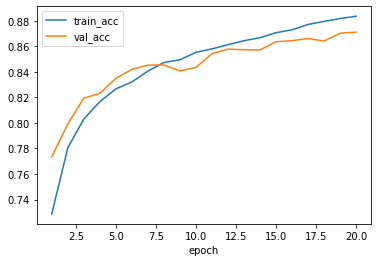

In [8]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['accuracy'],label='train_acc')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

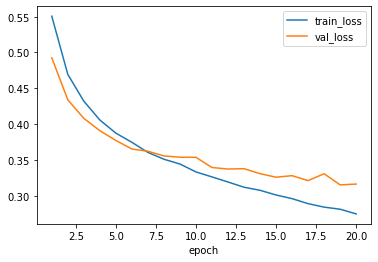

In [9]:
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['loss'],label='train_loss')
plt.plot(np.arange(1,num_epochs+0.1,dtype=int),
         history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# # save the model weights
# model.save_weights('GloVe_FeatureExtraction')

# 3. Predictions and Evaluations

In [12]:
# length of vocas in chars
voca_size=encoder.vocab_size

# number of RNN units
rnn_units=64

# batch size
batch_size=100

trained_model=LSTM_model(
    voca_size=voca_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

# load the model weights
trained_model.load_weights('model_param/GloVe_Feature_Extraction.h5')


In [13]:
# use the model to make prediction on the test set

test_outputs=trained_model(test_text)
test_pred=((test_outputs.numpy()>0.5)*1).flatten()


In [15]:
test_acc=sum(test_label==test_pred)/len(test_pred)
print('test_acc=',test_acc*100,'%')

test_acc= 87.1 %
